# Baseline Convolutional NN
This notebook will use a CNN model to classify images. This model will be a baseline, since I will also be bringing in a pretrained model (VGG-16) in a later notebook to create more accurate predictions.   

### Importing modules

In [3]:
from time import time
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Preparing the data

In [4]:
# dimensions of the images
img_width, img_height = 178, 218

train_data_dir = '../classification_data/train'
test_data_dir = '../classification_data/test'
epochs = 10
batch_size = 32

### Topology of basic model

In [5]:
# instantiating model
model = Sequential()

# Adding a convolutional 2D layer with a a pooling layer
model.add(Conv2D(32, (3, 3), input_shape=[178,218,1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a convolutional 2D layer with a a pooling layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a convolutional 2D layer with a a pooling layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a dense layer to flatten convolutional layers
model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))

# Final dense layer to produce output
model.add(Dropout(0.5))
model.add(Dense(8))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# currently unable to print out the CNN topology
# plot_model(model, to_file='baseline_model_topology.png')

### Reading in data

In [6]:
# this is the augmentation configuration we will use for training
datagen = ImageDataGenerator()

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = datagen.flow_from_directory(
        directory=train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True,
        color_mode = 'grayscale')

# this is a similar generator, for test data
test_generator = datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False,
        color_mode = 'grayscale')

Found 73411 images belonging to 8 classes.
Found 8530 images belonging to 8 classes.


#### Logging progress with Tensorboard

In [7]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

#### Fitting and running the model

In [8]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch= 73411//batch_size,
        epochs=epochs,
        callbacks = [tensorboard],
        verbose=1)

Epoch 1/10
2294/2294 [==============================] - 111s 48ms/step - loss: 11.6390 - acc: 0.2774
Epoch 2/10
2294/2294 [==============================] - 109s 47ms/step - loss: 11.6242 - acc: 0.2786
Epoch 3/10
2294/2294 [==============================] - 109s 47ms/step - loss: 11.5971 - acc: 0.2797
Epoch 4/10
2294/2294 [==============================] - 109s 47ms/step - loss: 11.5103 - acc: 0.2852
Epoch 5/10
2294/2294 [==============================] - 109s 47ms/step - loss: 11.5115 - acc: 0.2842
Epoch 6/10
2294/2294 [==============================] - 109s 47ms/step - loss: 11.5579 - acc: 0.2807
Epoch 7/10
2294/2294 [==============================] - 109s 47ms/step - loss: 11.5027 - acc: 0.2842
Epoch 8/10
2294/2294 [==============================] - 109s 47ms/step - loss: 11.2456 - acc: 0.2925
Epoch 9/10
2294/2294 [==============================] - 109s 47ms/step - loss: 11.2735 - acc: 0.2908
Epoch 10/10
2294/2294 [==============================] - 109s 47ms/step - loss: 11.2651 - a

### Evaluating the model on the test data, visualizing the model

In [9]:
# evaluate the model
loss, acc = model.evaluate_generator(test_generator, steps=8530// batch_size)
print('Cross-entropy: ', loss)
print('Accuracy: ', acc)

Cross-entropy:  10.26127341636142
Accuracy:  0.36336936090225563


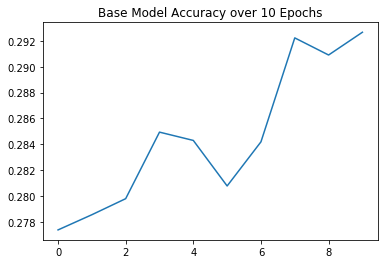

In [25]:
plt.plot(history.history['acc'])
plt.title('Base Model Accuracy over 10 Epochs')
plt.savefig('../images/aws_base_model_acc.png', bbox_inches='tight')

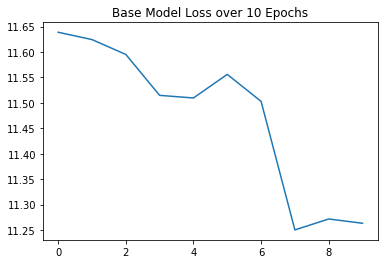

In [28]:
plt.plot(history.history['loss'])
plt.title('Base Model Loss over 10 Epochs')
plt.savefig('../images/aws_base_model_loss.png', bbox_inches='tight')

### Saving the model and the weights

In [29]:
# serialize model to JSON
base_model_json = model.to_json()
with open("../models_and_weights/aws_base_model.json", "w") as json_file:
    json_file.write(base_model_json)
    
# serialize weights to HDF5
model.save_weights("../models_and_weights/aws_base_model.h5")
print("Saved model to disk")

Saved model to disk


The model is achieving at about 43% accuracy in the test (validation) data, which is the baseline accuracy score of guessing the most frequently occuring class. In this instance, it seems that the model is not learning anything from the data.
Next steps:
- Using a pre-trained model
- Looking at the other metrics (precision, recall, specificity) to determine where the model is incorrectly classifying

In [30]:
%%time
test_generator.reset()
pred=model.predict_generator(test_generator, steps=8530/batch_size)

CPU times: user 9.19 s, sys: 328 ms, total: 9.52 s
Wall time: 8.17 s


In [31]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in np.argmax(pred,axis=1)]

In [32]:
filenames=test_generator.filenames

In [33]:
classes = [x.split('/')[0] for x in filenames]

In [34]:
len(classes)

8530

In [35]:
len(predictions)

8530

In [36]:
results=pd.DataFrame({"Filename":classes, "Predictions":predictions})

In [37]:
results.tail()

,Filename,Predictions
8525,51-60,21-30
8526,51-60,21-30
8527,51-60,21-30
8528,61-70,21-30
8529,61-70,21-30


Looking at the results, the model is only predicting a single class!

In [38]:
results.to_csv('../results/basic_cnn_model.csv',index=False)